In [29]:
import pandas as pd
from sklearn.metrics import precision_score, recall_score
import os
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [30]:
# ds_version = "V9"
ds_version = "V11"
root_data_path = os.path.join("..", "data", "training", ds_version)
data_path = os.path.join(root_data_path, "metadata")

In [31]:
# with cropping
# cropping_file_name = "all_train_effnet_surface_quality_prediction-V9_annotated-20240318_130115.csv"
cropping_file_name = 'effnet_surface_prediction-V11_annotated-20240408_143707.csv'

In [80]:
# with segmentation
# segment_file_name = "all_train_effnet_surface_quality_prediction-V9_annotated-20240403_181456.csv"
segment_file_name = 'effnet_surface_prediction_crop-V11_annotated-20240410_120029.csv'

In [81]:
crop_pred = pd.DataFrame()
# surface = file_name.split("_")[0]
print(f"reading {cropping_file_name}")
df = pd.read_csv(os.path.join(data_path, "model_predictions", cropping_file_name))
# df["surface_pred"] = surface
crop_pred = pd.concat([crop_pred, df])

crop_pred.rename(columns={"Image": "image_id", "Prediction": "surface_probability", "Level_0": "surface_label_pred"}, inplace=True)

reading effnet_surface_prediction-V11_annotated-20240408_143707.csv


In [82]:
seg_pred = pd.DataFrame()
# surface = file_name.split("_")[0]
print(f"reading {segment_file_name}")
df = pd.read_csv(os.path.join(data_path, "model_predictions", segment_file_name))
# df["surface_pred"] = surface
seg_pred = pd.concat([seg_pred, df])

seg_pred.rename(columns={"Image": "image_id", "Prediction": "seg_surface_probability", "Level_0": "seg_surface_label_pred", "Segment": "segment"}, inplace=True)

reading effnet_surface_prediction_crop-V11_annotated-20240410_120029.csv


In [83]:
crop_pred

,image_id,surface_probability,surface_label_pred,is_in_validation
0,1108901116248517,0.990364,asphalt,0.0
1,1108901116248517,0.007661,concrete,0.0
2,1108901116248517,0.001261,paving_stones,0.0
3,1108901116248517,0.000323,sett,0.0
4,1108901116248517,0.000391,unpaved,0.0
...,...,...,...,...
49895,959327628152817,0.000089,asphalt,0.0
49896,959327628152817,0.000075,concrete,0.0
49897,959327628152817,0.000077,paving_stones,0.0
49898,959327628152817,0.000146,sett,0.0


In [84]:
# the prediction holds a value for each surface and a class probability. Only keep the highest prob.
idx = crop_pred.groupby("image_id")["surface_probability"].idxmax()
crop_pred = crop_pred.loc[idx]

idx = seg_pred.groupby("image_id")["seg_surface_probability"].idxmax()
seg_pred = seg_pred.loc[idx]


In [85]:
# annot = pd.read_csv(os.path.join(data_path, "V9_annotations_combined.csv"))
annot = pd.read_csv(os.path.join(data_path, "annotations_combined.csv"))
annot.rename(columns={"surface": "surface_true", "smoothness": "quality_label_true"}, inplace=True)
# annot["quality_float_true"] = annot["quality_label_true"].map({"excellent": 1, "good": 2, "intermediate": 3, "bad": 4, "very_bad": 5})

In [86]:
df = crop_pred.set_index("image_id").join(seg_pred[["image_id", "seg_surface_probability", "seg_surface_label_pred", "segment"]].set_index("image_id"), how="left").join(annot[["image_id", "surface_true", "quality_label_true"]].set_index("image_id"), how="left")

In [87]:
# exclude not recognizable
df = df[df.surface_true.notna()]
# df = df[df.seg_surface_label_pred.notna()]

In [88]:
df.groupby(["surface_true", "quality_label_true"]).size()

surface_true   quality_label_true
asphalt        bad                    123
               excellent              783
               good                  1334
               intermediate           622
concrete       bad                     54
               excellent              189
               good                   340
               intermediate           249
paving_stones  bad                     30
               excellent              332
               good                   697
               intermediate           208
sett           bad                    518
               good                    97
               intermediate           658
unpaved        bad                    336
               intermediate           305
               very_bad               158
dtype: int64

In [89]:
# df_valid = df[df.is_in_validation == 1]
# df_train = df[df.is_in_validation == 0]

In [90]:
# df.groupby(["is_in_validation", "surface_true"]).size().to_csv("test.csv")

## Global measures

In [91]:
def compute_measures(true_label, pred_label):
    m = {
    "accuracy": sum(true_label == pred_label) / len(true_label),
    # "correlation": np.corrcoef(true_float, pred_float)[0, 1],
    # "r_square": r2_score(true_float, pred_float),
    # "mse": mean_squared_error(true_float, pred_float)
    }
    # m["rmse"] = np.sqrt(m["mse"])
    return m

In [92]:
# all
gm = compute_measures(df.surface_label_pred, df.seg_surface_label_pred)
# gm_valid = compute_measures(df_valid.surface_label_pred, df_valid.seg_surface_label_pred)
# gm_train = compute_measures(df_train.surface_label_pred, df_train.seg_surface_label_pred)
# pd.concat([pd.Series(gm, name="all"), pd.Series(gm_valid, name="validation"), pd.Series(gm_train, name="train")], axis=1).round(2)
gm

{'accuracy': 0.9923219109910423}

## with valid segmentation

In [93]:
df.shape

(7033, 8)

In [94]:
df = df[df.segment.notna()]
df = df[~df['segment'].isin(['','completely_segmented', 'not_completely_segmented'])]

In [95]:
df.shape

(2476, 8)

In [96]:
df.groupby(["surface_true", "quality_label_true"]).size()

surface_true   quality_label_true
asphalt        bad                    36
               excellent             269
               good                  467
               intermediate          225
concrete       bad                    26
               excellent              62
               good                  122
               intermediate          103
paving_stones  bad                     8
               excellent             123
               good                  243
               intermediate           69
sett           bad                   176
               good                   31
               intermediate          220
unpaved        bad                   129
               intermediate          115
               very_bad               52
dtype: int64

In [97]:
gm = compute_measures(df.surface_label_pred, df.seg_surface_label_pred)
# gm_valid = compute_measures(df_valid.surface_label_pred, df_valid.seg_surface_label_pred)
# gm_train = compute_measures(df_train.surface_label_pred, df_train.seg_surface_label_pred)
# pd.concat([pd.Series(gm, name="all"), pd.Series(gm_valid, name="validation"), pd.Series(gm_train, name="train")], axis=1).round(2)
gm

{'accuracy': 0.9781906300484653}

## compare classes

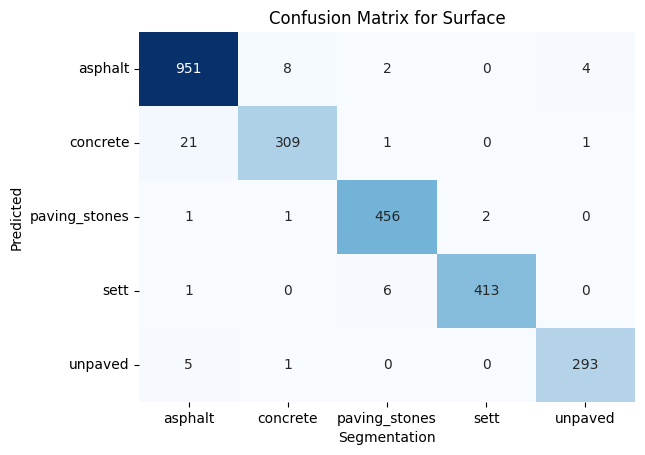

In [98]:
# Plotting the confusion matrix using seaborn heatmap

cm = confusion_matrix(df.surface_label_pred, df.seg_surface_label_pred, labels=["asphalt", "concrete", "paving_stones", "sett", "unpaved"])
plt.figure()
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["asphalt", "concrete", "paving_stones", "sett", "unpaved"],
            yticklabels=["asphalt", "concrete", "paving_stones", "sett", "unpaved"])
plt.title(f"Confusion Matrix for Surface")
plt.xlabel("Segmentation")
plt.ylabel("Predicted")
plt.show()

In [99]:
# Extract predicted and ground truth values

class_precision = precision_score(df.surface_label_pred, df.seg_surface_label_pred, average='weighted')
class_recall = recall_score(df.surface_label_pred, df.seg_surface_label_pred, average='weighted')

print(f"Count: {len(df)}")
print(f"Precision: {round(class_precision, 2)}")
print(f"Recall: {round(class_recall, 2)}")
print("------------------------")


Count: 2476
Precision: 0.98
Recall: 0.98
------------------------


In [100]:
# all images that were incorrectly classified
# misclassification = df[(df.surface_label_pred != df.surface_true) & (df.is_in_validation == 1)]
misclassification = df[(df.surface_label_pred != df.seg_surface_label_pred)]

In [101]:
misclassification = misclassification.sort_values("image_id")
misclassification.reset_index( inplace=True)
misclassification[["image_id", "is_in_validation", 
                    "surface_true", "surface_label_pred", "seg_surface_label_pred", "surface_probability", "seg_surface_probability", "segment"]
                    ].to_csv(os.path.join(data_path, "model_predictions", "seg_mis_surface.csv"), index=False)

In [102]:
# all images that were correctly classified
equiclassification = df[(df.surface_label_pred == df.seg_surface_label_pred)]

In [103]:
equiclassification = equiclassification.sort_values("image_id")
equiclassification.reset_index( inplace=True)
equiclassification[["image_id", "is_in_validation", 
                    "surface_true", "surface_label_pred", "seg_surface_label_pred", "surface_probability", "seg_surface_probability", "segment"]
                    ].to_csv(os.path.join(data_path, "model_predictions", "seg_correct_surface.csv"), index=False)

In [104]:
# TODO: update columns before saving
# df_comment = pd.DataFrame()
# df_tmp = pd.read_csv(os.path.join(data_path, "model_predictions", "seg_mis_surface_comments.csv"), encoding='unicode_escape')
# df_comment = pd.concat([df_comment, df])

# df_comment_prob = df_comment.set_index("image_id").join(df[["image_id", "surface_probability", "seg_surface_probability"]].set_index("image_id"), how="left")

In [105]:
# # store missclassified images in folder
# import shutil

# path = os.path.join(data_path, "model_predictions", "seg_mis_images", "surface")
# os.makedirs(path, exist_ok=True)
# for i in range(len(misclassification)):  # len(misclassification)
#     img = misclassification.loc[i]
#     img_path = os.path.join(root_data_path, "annotated")
#     destination_folder_path = os.path.join(path, img.surface_label_pred, img.seg_surface_label_pred)
#     os.makedirs(destination_folder_path, exist_ok=True)
#     destination_path = os.path.join(destination_folder_path, f"{img.image_id}.jpg")
#     image_filename = os.path.join(img_path, img.surface_true, img.quality_label_true, f"{img.image_id}.jpg")
#     shutil.copy(image_filename, destination_folder_path)

In [106]:
# store missclassified images in folder
# path = "/Users/alexandra/Nextcloud-HTW/SHARED/SurfaceAI/data/mapillary_images/training/V4/metadata/model_predictions/VGG16_V4_not_annotated/missclassified_wo_nostreet"
# os.makedirs(path, exist_ok=True)
# for image_id in misclassification_wo_nostreet.index:
#     destination_path = os.path.join(path, f"{image_id}.jpg")
#     image_filename = os.path.join("/Users/alexandra/Nextcloud-HTW/SHARED/SurfaceAI/data/mapillary_images/training/V4/unsorted_images", f"{image_id}.jpg")
#     shutil.copy(image_filename, destination_path)